# We Rate Dogs Data Review

## Gather

In this first section we will gather all of the relevent information that is going to be required for this project.

In [1]:
#Importing relevant packages
import pandas as pd
import datetime as dt
import numpy as np
import requests
import tweepy
import json
import re
import matplotlib
import matplotlib.pyplot as plt
from nltk import pos_tag

%matplotlib inline

matplotlib.style.use('seaborn-whitegrid')

In [2]:
archive = pd.read_csv('twitter-archive-enhanced.csv') # this is the original data file 
archive.set_index('tweet_id', inplace = True)
archive.head(5)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


The second file is a tsv file which is read and split into seperate columns in the following steps. The following tsv file contains the neural imaging data from each tweet and the softwares prediction for which type of breed the image is.

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(url.split('/')[-1], mode='wb') as file:
    file.write(response.content)
    
images = pd.read_csv('image-predictions.tsv', sep='\t')
images.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


Importing the data from tweepy to create the JSON file.

In [4]:
#Importing data from Tweepy
#This process can take 5-10 minutes
consumer_key = 'xxxxxxx'
consumer_secret = 'xxxxxxx'
access_token = 'xxxxxxx-xxxxxxx'
access_secret = 'xxxxxxx'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), wait_on_rate_limit=True)

### Creating a JSON file

The function below creates an empty list item, then appending each from column and row from the API into it's own dataframe.

In [5]:
#This process can take 5-10 minutes
df_list = []
e_list = []
tweet_id = images['tweet_id']

for id in tweet_id:
    try:
        page = api.get_status(id)
        favorites = page['favorite_count']
        retweet_count = page['retweet_count']
        day_time = pd.to_datetime(page['created_at'])
        df_list.append({'tweet_id': int(id),
                        'favorites': int(favorites),
                        'retweet_count': int(retweet_count)})
    
    except Exception as e:
        e_list.append(id)

In [6]:
#Rerunning the code to verify all errors are valid
e_list


[666020888022790149,
 666029285002620928,
 666033412701032449,
 666044226329800704,
 666049248165822465,
 666050758794694657,
 666051853826850816,
 666055525042405380,
 666057090499244032,
 666058600524156928,
 666063827256086533,
 666071193221509120,
 666073100786774016,
 666082916733198337,
 666094000022159362,
 666099513787052032,
 666102155909144576,
 666104133288665088,
 666268910803644416,
 666273097616637952,
 666287406224695296,
 666293911632134144,
 666337882303524864,
 666345417576210432,
 666353288456101888,
 666362758909284353,
 666373753744588802,
 666396247373291520,
 666407126856765440,
 666411507551481857,
 666418789513326592,
 666421158376562688,
 666428276349472768,
 666430724426358785,
 666435652385423360,
 666437273139982337,
 666447344410484738,
 666454714377183233,
 666644823164719104,
 666649482315059201,
 666691418707132416,
 666701168228331520,
 666739327293083650,
 666776908487630848,
 666781792255496192,
 666786068205871104,
 666804364988780544,
 666817836334

In [7]:
ee_list = []
for e in e_list:
    try:
        page = api.get_status(e)
        favorites = page['favorite_count']
        retweet_count = page['retweet_count']
        day_time = pd.to_datetime(page['created_at'])
        df_list.append({'tweet_id': int(e),
                        'favorites': int(favorites),
                        'retweet_count': int(retweet_count)})
        
    except Exception:
        ee_list.append(id)

We will need to read the json file into a dataframe, turning it into a CSV file.

In [8]:
jsondf = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweet_count'])
jsondf.to_csv('tweet_json.txt', encoding = 'utf-8')

In [9]:
jsondfo = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
jsondf = jsondfo.copy()# making a copy of the file
jsondf.set_index('tweet_id', inplace = True)
jsondf.tail(5)

,Unnamed: 0,favorites,retweet_count
tweet_id,,,


Finally we will merge the three files into a single dataset.

In [10]:
images.set_index('tweet_id', inplace = True)
df = pd.merge(left=archive, right=images, left_index=True, right_index=True, how='left') # Merging the first set of files
df = pd.merge(left=df, right=jsondf, left_index=True, right_index=True, how='left') #Merging the second set of files
df.to_csv('dfcopy.csv', encoding = 'utf-8') # making a copy of the file

In [11]:
dfo = pd.read_csv('dfcopy.csv') # then start here whenever I load the notebook while woring on it
df = dfo.copy()

## Assess

In this next section, we will analyze the datasets for any errors or changes that need to be made to the files. We will check the information and explore the data to get a better understanding of the information.

### About the Data
The datasets explores the database for the Weratedogs Twitter dataset. The data includes information about the ratings for each dog, their type, number of tweets and retweets, and more. The data was scrubbed from twitter using an API and detaield into a json, csv, and txt file which I've combined into one dataset.

### Exploring the data

In [12]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,Unnamed: 0,favorites,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,False,bagel,0.085851,False,banana,0.076110,False,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,True,Pekinese,0.090647,True,papillon,0.068957,True,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,True,malamute,0.078253,True,kelpie,0.031379,True,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,NaN,NaN,NaN


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                       20

In [14]:
df.shape

(2356, 31)

In [15]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf,Unnamed: 0,favorites,retweet_count
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000,2075.000000,2075.000000,2.075000e+03,2.075000e+03,0.0,0.0,0.0
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433,1.203855,0.594548,1.345886e-01,6.032417e-02,NaN,NaN,NaN
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237,0.561875,0.271174,1.006657e-01,5.090593e-02,NaN,NaN,NaN
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,NaN,NaN,NaN
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000,1.000000,0.364412,5.388625e-02,1.622240e-02,NaN,NaN,NaN
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000,1.000000,0.588230,1.181810e-01,4.944380e-02,NaN,NaN,NaN
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000,1.000000,0.843855,1.955655e-01,9.180755e-02,NaN,NaN,NaN
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,NaN,NaN,NaN


In [16]:
df['name'].value_counts()

None        745
a            55
Charlie      12
Oliver       11
Lucy         11
Cooper       11
Tucker       10
Lola         10
Penny        10
Winston       9
Bo            9
the           8
Sadie         8
an            7
Bailey        7
Daisy         7
Toby          7
Buddy         7
Scout         6
Bella         6
Oscar         6
Dave          6
Leo           6
Koda          6
Stanley       6
Jack          6
Jax           6
Milo          6
Rusty         6
Oakley        5
           ... 
Eugene        1
Kendall       1
Mabel         1
Ben           1
Ginger        1
Pherb         1
Crawford      1
Horace        1
Brockly       1
Napolean      1
Clarkus       1
Edd           1
Jessifer      1
Tessa         1
Steve         1
Iggy          1
Flurpson      1
Autumn        1
Emma          1
Crouton       1
Buddah        1
Apollo        1
Tom           1
Striker       1
Holly         1
Callie        1
Juckson       1
Edmund        1
Bilbo         1
all           1
Name: name, Length: 957,

In [17]:
df['rating_numerator'].value_counts()
df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

## Explore Analysis

##### Number of rows

Image data frame has 2075 rows

Archie data frame has 2356 rows

- **tweet_id**: The unique identififer for each tweet in the tweet table for we rate dogs dataset
- **in_reply_status_id**: The unique identifer for the tweet reply
- **in_reply_to_user_id**: The unique idenfier for the user who posted a reply
- **timestamp**: The date and time the tweet was posted
- **source**: The platform that the tweet was posted from
- **text**: The text contained in the tweet
- **retweeted_status_id**: The unique identifer for the retweeted post
- **retweeted_status_user_id**: The unique user if for the retweeted post
- **retweeted_staus_timestamp**: The time stamp of the retweet
- **expanded_urls**: The photo URL
- **rating_numerator**: The posted score for the dog
- **rating_denominator**: The denominator for the highest value
- **jpg_url** The url for the image
- **img_num** The number the image is
- **name**: The name of the dog
- **doggo**: The type of dog
- **floofer**: The type of dog
- **pupper**: The type of dog
- **puppo**: The type of dog
- **p1**: The algorithm's #1 prediction for the image in the tweet
- **p1_conf**: How confident the algorithm is in its #1 prediction
- **p1_dog**: Whether or not the #1 prediction is a breed of dog
- **p2**:  The algorithm's second most likely prediction
- **p2_conf**: How confident the algorithm is in its #2 prediction    
- **p2_dog**: Whether or not the #2 prediction is a breed of dog     
- **p3**:   The algorithm's third most likely prediction           
- **p3_conf**: How confident the algorithm is in its #3 prediction
- **p3_dog**: Whether or not the #3 prediction is a breed of dog
- **Unnamed: 0**: Error column
- **favorites**: Number of times the tweet was favorited
- **retweet_count**: Number of times the tweet was retweeted

### Assessing the Issues

### Quality
- Convert datatime data times to timestamp
- Remove retweets
- Remove additional index
- Correct ratings for incorrect data
- Set denominator to correct value
- Incorrect dog names
- Set appropriate entries for missing data
- Extract correct HTML data



### Tidiness
- Combine dog stages into a single column
- Combine dog breeds together

# Clean


### Convert Timestamp Column to Datetime
#### Define:
Convert the timestamp column to a datetime datatype, this will also remove the 0000's at the end.

#### Code:

In [18]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

#### Test:

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns, UTC]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url            

### Delete Retweets and Remove Unnamed Column
#### Define:
For this study, we are not going to include posts that are retweets. There is also a secondary index column named Unnamed that will need to be removed.

#### Code:

In [20]:
#Removing the files with no pictures and extra retweets
del df['Unnamed: 0'] 
df = df[pd.notnull(df['jpg_url'])] #no pictures
df = df[pd.isnull(df['retweeted_status_id'])] #extra retweets

In [21]:
#Removing the extra unnesseary columns
del df['retweeted_status_id']
del df['retweeted_status_user_id']
del df['retweeted_status_timestamp']

In [22]:
#Drop redundent columns
df.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1, inplace=True)

#### Test:

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null datetime64[ns, UTC]
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
doggo                 1994 non-null object
floofer               1994 non-null object
pupper                1994 non-null object
puppo                 1994 non-null object
jpg_url               1994 non-null object
img_num               1994 non-null float64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null object
p2                    1994 non-null object
p2_conf               1994 non-null float64
p2_dog                1994 non-null object
p3                  

### Combine Dog Stages
#### Define
The dog stages are currently split up into their own columns, creating extra data that is unneccessary. We will combine the dog stages into a single column and then remove all the none values.

#### Code:

In [24]:
#Creating a function to add the dog types into a single column.
dog_type = []

string_in = ['puppo', 'pupper', 'doggo', 'floof']
string_out = ['puppo', 'pupper', 'doggo', 'floofer']

for row in df['text']:
    row = row.lower()
    for word in string_in:
        if word in str(row):
            dog_type.append(string_out[string_in.index(word)])
            break
    else:
        dog_type.append('None')
        
#Removing extra column
df.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test:

In [25]:
df['dog_type'] = dog_type
df['dog_type'].value_counts()

None       1625
pupper      237
doggo        69
floofer      34
puppo        29
Name: dog_type, dtype: int64

### Combine Dog Breeds
#### Define:
In this step, we are going to combine the dog breeds into a single column

#### Code:

In [26]:
# function to combine dog breeds
breed = []
confidence = []

def breed_confidence(row):
    if row['p1_dog'] == True:
        breed.append(row['p1'])
        confidence.append(row['p1_conf'])
    elif row['p2_dog'] == True:
        breed.append(row['p2'])
        confidence.append(row['p2_conf'])
    elif row['p3_dog'] == True:
        breed.append(row['p3'])
        confidence.append(row['p3_conf'])
    else:
        breed.append('Unidentifiable')
        confidence.append(0)
      
    # Removing extra data

df.apply(breed_confidence, axis=1)
df['breed'] = breed
df['confidence'] = confidence


#### Test:

In [27]:
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorites,retweet_count,dog_type,breed,confidence
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,...,0.085851,False,banana,0.076110,False,NaN,NaN,None,Unidentifiable,0.000000
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,...,0.090647,True,papillon,0.068957,True,NaN,NaN,None,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,...,0.078253,True,kelpie,0.031379,True,NaN,NaN,None,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,...,0.168086,True,spatula,0.040836,False,NaN,NaN,None,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,...,0.225770,True,German_short-haired_pointer,0.175219,True,NaN,NaN,None,basset,0.555712


### Extract the ratings from the columns
#### Define:
In order to determine the correct rating for the dogs, I'm going to extract each rating and insert int into a new column.


#### Code:

In [28]:
rates = []

extract_rates = lambda x: rates.append(re.findall(r'(\d+(\.\d+)|(\d+))\/(\d+0)', x, flags=0))

df['text'].apply(extract_rates)

numerator = []
dog_count = []

for item in rates:
    
    # function for tweets with no rating, but a picture, so a dog
    if len(item) == 0:
        numerator.append('NaN')
        dog_count.append(1)
        
    # function for tweets with one rating and one dog
    elif len(item) == 1 and item[0][-1] == '10':
        numerator.append(float(item[0][0]))
        dog_count.append(1)
   
    # function for group ratings
    elif len(item) == 1: 
        avg = float(item[0][0]) / (float(item[0][-1]) / 10) 
        numerator.append(avg)
        dog_count.append(float(item[0][-1]) / 10)
   
    # function for tweets with more than one rating
    elif len(item) > 1: 
        total = 0
        list = []
        for i in range(len(item)):
            if item[i][-1] == '10': #excluding 10/10 rating
                list.append(item[i])
        for rate in list:
            total = total + float(rate[0])
        avg = total / len(item)
        numerator.append(avg)
        dog_count.append(len(item))
   
    # catching anyting not covered
    else:
        numerator.append('Not parsed')
        dog_count.append('Not parsed') 
        
df['rating'] = numerator #creates a base denominator
df['dog_count'] = dog_count
df['rating'].value_counts()

12.0                 453
10.0                 411
11.0                 399
13.0                 261
9.0                  152
8.0                   94
7.0                   52
14.0                  36
6.0                   32
5.0                   30
3.0                   19
4.0                   14
2.0                    9
8.5                    4
1.0                    4
7.5                    3
9.5                    3
5.5                    2
6.5                    2
10.5                   2
0.0                    2
1776.0                 1
9.75                   1
9.666666666666666      1
4.5                    1
11.27                  1
13.5                   1
420.0                  1
11.5                   1
NaN                    1
11.26                  1
Name: rating, dtype: int64

In [29]:
#Droping the now unncessary columns since it's no longer needed
df.drop([ 'rating_numerator', 'rating_denominator'], axis=1, inplace=True)


#### Test:

In [30]:
df['dog_count'].value_counts()


1.0     1958
2.0       23
5.0        2
8.0        2
3.0        1
12.0       1
11.0       1
13.0       1
4.0        1
9.0        1
17.0       1
15.0       1
7.0        1
Name: dog_count, dtype: int64

### Extracting Names for Error Values
#### Define:

Extrct and correct the names in the name columns

#### Code:

In [31]:
df['text_split'] = df['text'].str.split()


In [32]:
names = []

#using a string method to clean up the data

def extract_names(row):
    
    # 'This is Charlie'
    if row['text'].startswith('This is ') and re.match(r'[A-Z].*', row['text_split'][2]):
            names.append(row['text_split'][2].strip('.').strip(','))
    
    # 'Meet Charlie'
    elif row['text'].startswith('Meet ') and re.match(r'[A-Z].*', row['text_split'][1]):
            names.append(row['text_split'][1].strip('.').strip(','))
    
    # 'Say hello to Charlie'
    elif row['text'].startswith('Say hello to ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
    
    # 'Here we have Charlie'
    elif row['text'].startswith('Here we have ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
    
    # 'named Charlie'           
    elif 'named' in row['text'] and re.match(r'[A-Z].*', row['text_split'][(row['text_split'].index('named') + 1)]): 
            names.append(row['text_split'][(row['text_split'].index('named') + 1)])
            
    else:
        names.append('Nameless')
        
        
df.apply(extract_names, axis=1)

len(names)
df['names'] = names
df.drop('name', axis = 1, inplace = True)


#### Test:

In [33]:
df['names'].value_counts()

Nameless     625
Charlie       11
Oliver        10
Cooper        10
Lucy          10
Penny          9
Tucker         9
Sadie          8
Winston        8
Daisy          7
Lola           7
Bella          6
Stanley        6
Jax            6
Koda           6
Toby           6
Bo             6
Chester        5
Scout          5
Bailey         5
Buddy          5
Oscar          5
Louis          5
Milo           5
Rusty          5
Leo            5
Scooter        4
Sophie         4
Cassie         4
Gus            4
            ... 
Sprout         1
Caryl          1
Eve            1
Kramer         1
Emma           1
Brockly        1
Jamesy         1
Autumn         1
Baloo          1
Zeus.          1
Adele          1
Rooney         1
Timison        1
Brian          1
Paull          1
Kathmandu      1
Ronduh         1
Jangle         1
Jennifur       1
Napolean       1
Clarkus        1
Edd            1
Tickles.       1
Zuzu           1
Tessa          1
Steve          1
Iggy           1
Flurpson      

### Set Appropriate Values to Certain Columns
#### Define:
For better analysis, setting values of 'none, etc' to None


In [34]:
df.loc[df['names'] == 'Nameless', 'names'] = None
df.loc[df['breed'] == 'Unidentifiable', 'breed'] = None
df.loc[df['dog_type'] == 'None', 'dog_type'] = None
df.loc[df['rating'] == 0.0, 'rating'] = np.nan
df.loc[df['confidence'] == 0.0, 'confidence'] = np.nan

#### Test

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id         1994 non-null int64
timestamp        1994 non-null datetime64[ns, UTC]
source           1994 non-null object
text             1994 non-null object
expanded_urls    1994 non-null object
jpg_url          1994 non-null object
img_num          1994 non-null float64
p1               1994 non-null object
p1_conf          1994 non-null float64
p1_dog           1994 non-null object
p2               1994 non-null object
p2_conf          1994 non-null float64
p2_dog           1994 non-null object
p3               1994 non-null object
p3_conf          1994 non-null float64
p3_dog           1994 non-null object
favorites        0 non-null float64
retweet_count    0 non-null float64
dog_type         369 non-null object
breed            1686 non-null object
confidence       1686 non-null float64
rating           1992 non-null object
dog_count        1994 non-null float64
text_s

### Remove html data from source
#### Define
We will be removing the excess HTML tag data from the **source** column for better analysis.

#### Code

In [36]:
df['source'] = df['source'].str.split('>').str.get(1)
df['source'] = df['source'].str.split('<').str.get(0)

#### Test

In [37]:
df['source'].value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

## Visualization and Analysis

#### Retweets, Favorites and Ratings Correlation

Text(0, 0.5, 'Count')

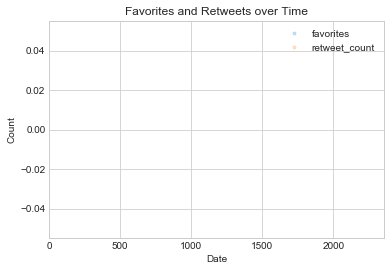

In [38]:
df[['favorites', 'retweet_count']].plot(style = '.', alpha = .2)
plt.title('Favorites and Retweets over Time')
plt.xlabel('Date')
plt.ylabel('Count')

#### Visual for Most Rated Breeds

Text(0, 0.5, 'Breed')

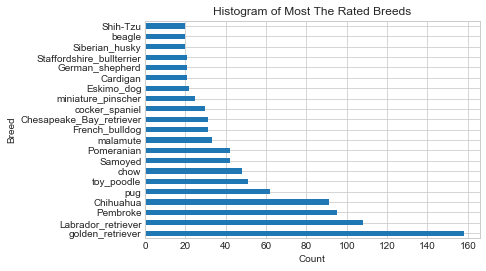

In [39]:
top_breeds=df.groupby('breed').filter(lambda x: len(x) >= 20)
top_breeds['breed'].value_counts().plot(kind = 'barh')
plt.title('Histogram of Most The Rated Breeds')
plt.xlabel('Count')
plt.ylabel('Breed')

In [40]:
top_breeds.groupby('breed')['rating'].describe()


,count,unique,top,freq
breed,,,,
Cardigan,21.0,6.0,11.0,6.0
Chesapeake_Bay_retriever,31.0,8.0,10.0,10.0
Chihuahua,91.0,12.0,12.0,23.0
Eskimo_dog,22.0,6.0,12.0,7.0
French_bulldog,31.0,7.0,12.0,9.0
German_shepherd,21.0,6.0,12.0,7.0
Labrador_retriever,108.0,9.0,12.0,31.0
Pembroke,95.0,10.0,12.0,30.0
Pomeranian,42.0,8.0,12.0,13.0


In [41]:
df['rating'].describe()

count     1992.0
unique      30.0
top         12.0
freq       453.0
Name: rating, dtype: float64

##### Quick Analysis: 
The data shows us that Golden Retreivers are the most rate breeds followed by a large margin by labador retrivers. Further analaysis would be required for the reasoning but it is a common believe that Golden Retrivers are some of the most reliable and friendly dogs.

#### Dog Stages Stats


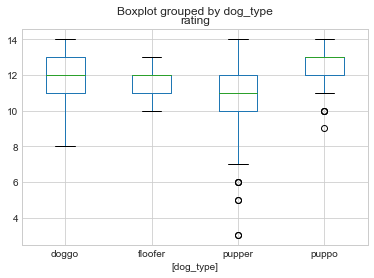

In [42]:
df.boxplot(column=['rating'], by=['dog_type']);


In [43]:
df.groupby('dog_type')['rating'].describe()


,count,unique,top,freq
dog_type,,,,
doggo,69.0,6.0,11.0,20.0
floofer,34.0,4.0,12.0,18.0
pupper,237.0,14.0,11.0,59.0
puppo,29.0,6.0,13.0,14.0


##### Quick Analysis:
The puppo stage has a much lower rate than the other stages of dogs. Floofers has a consistent range of having a high rating.

In [44]:
df.to_csv('twitter_archive_master.csv', encoding = 'utf-8') #saved